In [1]:
import FI_estimation
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy import ndimage

torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

/home/maximilian/anaconda3/envs/ML/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# regular experimental data
type = np.float64
x_tr = np.load("Data"+os.sep+"x_tr.npy")
y_tr = np.load("Data"+os.sep+"y_tr.npy")
x_tst = np.load("Data"+os.sep+"x_tst.npy")
delta = 0.3
#
# crop the positions
steps = 13
x_tr = x_tr.reshape(steps,50000,1,18,24)
y_tr = y_tr.reshape(steps,50000)
idx = np.arange(50000)
np.random.shuffle(idx)
x_tr = x_tr[:,idx]
y_tr = y_tr[:,idx]
#
y_tr = y_tr.reshape(y_tr.shape[0]*y_tr.shape[1])
x_tr = x_tr.reshape(x_tr.shape[0]*x_tr.shape[1],1,18,24)
print("training sample size: ", y_tr.shape[0])

training sample size:  650000


In [3]:
def shuffle_split_data(X, y, ratio=0.5):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, ratio*100)

    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test = y[~split]
    return X_train, X_test, y_train, y_test

a = x_tr.shape[0]
std = np.std(x_tr, axis=0)
std[std==0] = 1
mean = np.mean(x_tr, axis=0)

for i in range(a): 
    x_tr[i] = (x_tr[i]-mean)/std
for i in range(x_tst.shape[0]): 
    x_tst[i] = (x_tst[i]-mean[0])/std[0]
# ###
# cf = 4 * (np.max(y_tr)/2)**2
# print("multiply the output variance with", cf)
# y_tr = y_tr-np.min(y_tr)
# y_tr = 2 * ( y_tr / np.max(y_tr) - 0.5 )

X_train, X_val, Y_train, Y_val = shuffle_split_data(x_tr, y_tr, ratio=0.8)
x_tr = None
y_tr = None

X_train = X_train.astype(type)
Y_train = Y_train.astype(type)
X_val = X_val.astype(type)
Y_val = Y_val.astype(type)
x_tst = x_tst.astype(np.float64)

In [4]:
torch.set_default_tensor_type(torch.DoubleTensor)
train_set = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train).T)
val_set = TensorDataset(torch.tensor(X_val), torch.tensor(Y_val).T)

bs = 128
train_loader = Data.DataLoader(train_set, batch_size=bs, shuffle=True)
validation_loader = Data.DataLoader(val_set, batch_size=bs, shuffle=True)

/tmp/ipykernel_22516/1397782601.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755832681/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  train_set = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train).T)


In [5]:
class Model(nn.Module):
    def __init__(self, n):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(n[0], n[1])
        self.linear2 = nn.Linear(n[1], n[2])
        self.linear3 = nn.Linear(n[2], n[3])
        self.linear4 = nn.Linear(n[3], n[4])
        self.linear5 = nn.Linear(n[4], n[5])
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)    
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)       
        x = F.relu(x)
        x = self.linear5(x)  
        return x
n=[18*24,800,100,25,5,1]

In [ ]:
starting_epoch = 0
criterion =  nn.MSELoss()
n_epochs = 25
lr = 5e-7
training_loss = 0.
validation_loss = 0.
net = Model(n).to(device)
all_losses = []
all_losses_val = []
all_losses.append(training_loss/len(train_loader))
all_losses_val.append(validation_loss/len(validation_loader))
torch.save(net,  'Models' +os.sep+ 'epoch' + str(0)+'Experimental.pth')

for epoch in range(starting_epoch, starting_epoch + n_epochs):
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.003)
    net.train()
    training_loss = 0.
    validation_loss = 0.
    batch_count = 0
30
    net.eval()
31
    with torch.no_grad():
32
        for inputs, target in validation_loader:
33
            inputs = inputs.to(device)
34
            target = target.to(device)
35
            y_pred = net(inputs)
    for inputs, target in train_loader:
        inputs = inputs.to(device)
        target = target.to(device)
        batch_count += 1
        y_pred = net(inputs)
        loss = criterion(y_pred,  torch.unsqueeze(target,dim=1)  )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    net.eval()
    with torch.no_grad():
        for inputs, target in validation_loader:
            inputs = inputs.to(device)
            target = target.to(device)
            y_pred = net(inputs)
            loss_val = criterion(y_pred,  torch.unsqueeze(target,dim=1) )
            validation_loss += loss_val.item()
    print("epoch= ", epoch, ", val= ", validation_loss/len(validation_loader),", train = ", training_loss/len(train_loader))
    torch.save(net,   'Models' +os.sep+ 'epoch' + str(epoch+1)+'Experimental.pth')
    all_losses_val.append(validation_loss/len(validation_loader))
    all_losses.append(training_loss/len(train_loader))

epoch=  0 , val=  1.2519757605038562 , train =  1.2566414157615005
epoch=  1 , val=  1.2341606006109915 , train =  1.2444794588300487
epoch=  2 , val=  1.2062760364595086 , train =  1.2216271786628


In [28]:
# np.savez('Plots'+os.sep+'losses_SpaceInvader.npz',
#          all_losses=all_losses,
#         all_losses_val = all_losses_val)

In [6]:
# x_tst = x_tst.astype(np.float64)
# x_minus = x_tst[0]
# x_middle = x_tst[1]
# x_plus = x_tst[2]

In [6]:
### calculating the FI Flow for different runs:
### parameters 
fi_in = 1.6
kappa = 0.1 # ratio of slopes
gamma = 0.05 # stop when the LFI doesn't improve in the first iterations 
noise = 0.01 # noise added
step = 30 # 10 increase of dimensionality
upperLimit = 200 # maximum increase 
n_epochs = 20
X = x_tst
#X = X.reshape(X.shape[0]*X.shape[1], X.shape[2]) 
X = torch.tensor(X)
print("X.shape", X.shape)
fi_array = []
for epoch in range(n_epochs):
    net = Model(n)
    net = torch.load('Models'+os.sep + 'epoch'+ str(epoch)+'Experimental.pth', map_location=torch.device('cpu'))
    net.eval()
    ###
    return_nodes = {
        "linear1": "linear1",
        "linear2": "linear2",
        "linear3": "linear3",
        "linear4": "linear4"}
    model2 = create_feature_extractor(net, return_nodes=return_nodes)
    intermediate_outputs = model2(X)

    linear1 = intermediate_outputs['linear1']
    linear2 = intermediate_outputs['linear2']
    linear3 = intermediate_outputs['linear3']
    linear4 = intermediate_outputs['linear4']
    layer_out = net(X)
    ##############
    linear1 = linear1.reshape(3 , linear1.shape[0]//3, linear1.shape[1])
    linear2 = linear2.reshape(3 , linear2.shape[0]//3, linear2.shape[1])
    linear3 = linear3.reshape(3 , linear3.shape[0]//3, linear3.shape[1])
    linear4 = linear4.reshape(3 , linear4.shape[0]//3, linear4.shape[1])
    layer_out = layer_out.reshape(3 , layer_out.shape[0]//3, layer_out.shape[1])
    ### converst to numpy arrays
    linear1 = linear1.detach().numpy()
    linear2 = linear2.detach().numpy()
    linear3 = linear3.detach().numpy()
    linear4 = linear4.detach().numpy()
    layer_out = layer_out.detach().numpy()

    linear1 = (FI_estimation.ReLU(linear1))
    linear2 = (FI_estimation.ReLU(linear2))
    linear3 = (FI_estimation.ReLU(linear3))
    linear4 = (FI_estimation.ReLU(linear4))
    layer_out = (layer_out)
    ### it might not converge without noise!
#     fi_1_temp = FI_estimation.get_LFI(linear1, delta, 1e-9)
#     fi_2_temp = FI_estimation.get_LFI(linear2, delta, 1e-9)
#     fi_3_temp = FI_estimation.get_LFI(linear3, delta, 1e-9)
#     fi_4_temp = FI_estimation.get_LFI(linear4, delta, 1e-9)
#     fi_out_temp = FI_estimation.get_LFI(layer_out, delta, 1e-9)

    fi_1 = FI_estimation.get_FI(linear1, delta, upperLimit, step, kappa, constant_threshold=gamma, 
                               noise_factor=noise, biasedLFI=True)
    fi_2 = FI_estimation.get_FI(linear2, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)
    fi_3 = FI_estimation.get_FI(linear3, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)
    fi_4 = FI_estimation.get_FI(linear4, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)
    fi_out = FI_estimation.get_FI(layer_out, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)

#     fi_1 = max(fi_1_temp, fi_1)
#     fi_2 = max(fi_2_temp, fi_2)
#     fi_3 = max(fi_3_temp, fi_3)
#     fi_4 = max(fi_4_temp, fi_4)
#     fi_out = max(fi_out_temp[0], fi_out)
    if isinstance(fi_out, np.ndarray): fi_out = fi_out.item()
    fi = np.array([fi_in,fi_1,fi_2,fi_3,fi_4,fi_out])
    print(fi)
    fi_array.append(fi)
    print("#------------------------------------------------------#")

X.shape torch.Size([450000, 18, 24])
calculating FI
up:  0


KeyboardInterrupt: 

In [13]:
linear1.shape

NameError: name 'linear1' is not defined

In [35]:
net = Model(n)
net = torch.load('Models'+os.sep + 'epoch'+ str(epoch)+'Experimental.pth', map_location=torch.device('cpu'))
net.eval()
###
return_nodes = {
    "linear1": "linear1",
    "linear2": "linear2",
    "linear3": "linear3",
    "linear4": "linear4"}
model2 = create_feature_extractor(net, return_nodes=return_nodes)
intermediate_outputs = model2(X)

linear1 = intermediate_outputs['linear1']
linear2 = intermediate_outputs['linear2']
linear3 = intermediate_outputs['linear3']
linear4 = intermediate_outputs['linear4']
layer_out = net(X)
##############
linear1 = linear1.reshape(3 , linear1.shape[0]//3, linear1.shape[1])
linear2 = linear2.reshape(3 , linear2.shape[0]//3, linear2.shape[1])
linear3 = linear3.reshape(3 , linear3.shape[0]//3, linear3.shape[1])
linear4 = linear4.reshape(3 , linear4.shape[0]//3, linear4.shape[1])
layer_out = layer_out.reshape(3 , layer_out.shape[0]//3, layer_out.shape[1])
### converst to numpy arrays
linear1 = linear1.detach().numpy()
linear2 = linear2.detach().numpy()
linear3 = linear3.detach().numpy()
linear4 = linear4.detach().numpy()
layer_out = layer_out.detach().numpy()

In [12]:
list(net.children())

[Linear(in_features=432, out_features=800, bias=True),
 Linear(in_features=800, out_features=100, bias=True),
 Linear(in_features=100, out_features=25, bias=True),
 Linear(in_features=25, out_features=5, bias=True),
 Linear(in_features=5, out_features=1, bias=True)]

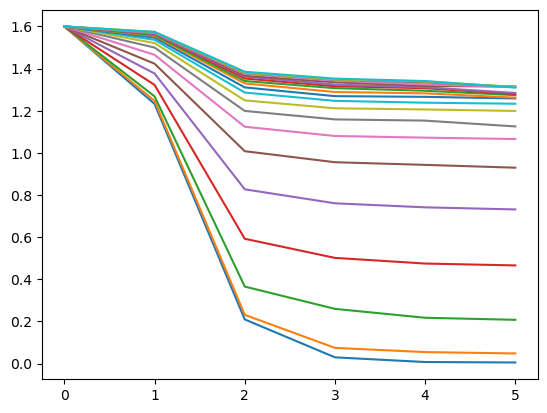

In [7]:
plt.plot(np.array(fi_array).T)

In [8]:
#np.save("Plots" + os.sep + "fi_flow_SpaceInvader.npy", np.array(fi_array))

### trash

In [7]:
def get_LFI(data, delta, cutoff):
    mu = np.mean(data, axis=1)
    dmu = (mu[2]-mu[0])/(2*delta)
    cov = np.cov(data[1].T)#(np.cov(data[0].T)+np.cov(data[2].T))/2
    if data.shape[2] > 1:
        u, s, vh = np.linalg.svd(cov, full_matrices=True)
        count = 0
        s_inv = np.zeros(shape=s.shape[0])
        for i in range(s.shape[0]):
            if np.abs(s[i])<cutoff:
                count += 1
                s[i] = 0.
            else:
                s_inv[i] = 1/s[i]
        if count > 0:
            print("components ignored: ", count)
        lfi = dmu.T@vh.T@np.diag(s_inv)@u.T@dmu  
    elif data.shape[2] == 1:
        lfi = dmu**2/cov
    else:
        print("wrong shape of data")
    T = data.shape[1]
    N = data.shape[2]
    return lfi - 2*N/(T*(2*delta)**2)
#get_LFI(linear1, delta, 1e-9)

In [9]:
data_in = x_tst.reshape(3,x_tst.shape[0]//3,x_tst.shape[1]*x_tst.shape[2])

In [14]:
get_LFI(data_in, delta, 1e-9)

1.6753797669166657

In [15]:
curve = FI_estimation.get_FI_curve(data_in, delta, 500, 100, 0.1, constant_threshold=0.05, noise_factor=0.01, biasedLFI=True)


lfi =  1.5260569730531885
lfi =  1.6087787722671536
lfi =  1.6373080577052714
lfi =  1.6454209191389941
lfi =  1.651405508934027


In [16]:
upperLimit = 500
curve = FI_estimation.get_FI_curve(linear1, delta, upperLimit, 100, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)


lfi =  1.2021906624369452
lfi =  1.231580063933581
lfi =  1.2513650510439547
lfi =  1.2548664189182694
lfi =  1.260035479234393


In [11]:
curve[0] = 1.27407766

In [16]:
x = []
for up in range(0,upperLimit,step):
    x.append(up)
x = np.array(x)
curve = np.array(curve)
np.savez('Plots'+os.sep+'FIConvergenceExperimental.npz',
         curve=curve,
        x=x)